In [8]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import csv
from torch import nn
from sklearn.utils import class_weight
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

torch.manual_seed(0)

DATA_PATH = '/home/skrhakv/cryptic-nn/data'
ESM_EMBEDDINGS_PATH = f'{DATA_PATH}/embeddings'
MODELS_PATH = f'{DATA_PATH}/models'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Load the dataset

In [2]:
class SequenceCryptoBenchDataset(Dataset):
    def __init__(self, _Xs, _Ys):
        _Xs_list = []
        _Ys_list = []
        for key, _ in _Xs.items():
            print(f'Processing {key} ...')
            _Xs_list.append(_Xs[key])
            _Ys_list.append(_Ys[key])

        print('Concatenating ...')
        Xs_list = np.concatenate(_Xs_list, axis=0)
        Ys_list = np.concatenate(_Ys_list, axis=0)

        print('Converting to torch tensor ...')
        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        self.Ys = torch.tensor(Ys_list, dtype=torch.int64)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y

def process_sequence_dataset(annotation_path, embeddings_paths):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[4]

            if row[3] == '':
                continue
            
            # load the precomputed embedding
            if id not in Xs:
                for embeddings_path in embeddings_paths:
                    filename = id + '.npy'
                    embedding = np.load(f'{embeddings_path}/{filename}')
                    if id not in Xs:
                        Xs[id] = embedding
                    else:
                        Xs[id] = np.concatenate((Xs[id], embedding), axis = 1)
                    

            # load the annotations denoting whether particular residue is binding or not
            # we use binary annotation: 0=non-binding; 1=binding
            if id not in Ys:
                Ys[id] = np.zeros(embedding.shape[0])
            for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in row[3].split(' ')]:
                assert sequence[residue_idx] == aa
                Ys[id][residue_idx] = 1

    return Xs, Ys

In [5]:
DROPOUT = 0.3
LAYER_WIDTH = 100
ESM2_DIM = 2560
PROTBERT_DIM = 1024

class CryptoBenchClassifier(nn.Module):
    def __init__(self, input_dim=ESM2_DIM):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=LAYER_WIDTH)
        self.dropout1 = nn.Dropout(DROPOUT)

        self.layer_2 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.layer_3 = nn.Linear(in_features=LAYER_WIDTH, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.dropout2(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))


def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

torch.manual_seed(42)

def train(model, optimizer, epochs, batch_size, loss_fn, train_dataset, test_dataset):
    model = model.to(device)

    # Create an optimizer
    _, y_train = train_dataset[:]
    X_test, y_test, = test_dataset[:]

    # compute class weights (because the dataset is heavily imbalanced)
    class_weights = compute_class_weights(y_train.numpy()).to(device)
    print(f'Class weights: ', class_weights)
    # BCEWithLogitsLoss - sigmoid is already built-in!
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

    X_test, y_test = X_test.to(device), y_test.to(device).float()

    train_losses, test_losses = [], []

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        #
        # TEST
        #
        model.eval()
        with torch.inference_mode():

            test_logits = model(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits,
                                y_test)
            test_losses.append(test_loss.cpu().detach().numpy())

            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=y_test,
                                   y_pred=test_pred)
            fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())

        #
        # TRAIN
        #
        batch_losses = []
        for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).float()

            model.train()

            y_logits = model(x_batch).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits,
                           y_batch)
            acc = accuracy_fn(y_true=y_batch,
                              y_pred=y_pred)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            batch_losses.append(loss.cpu().detach().numpy())

        train_losses.append(sum(batch_losses) / len(batch_losses))
        #if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}, sum: {sum(test_pred)}")

    plt.plot(train_losses,label="train loss over epochs")
    plt.plot(test_losses,label="test loss over epochs")
    plt.legend()
    plt.show()

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return fpr, tpr, roc_auc


# Train a classifier on APO sequences and evaluate on APO sequences

In [9]:
Xs_train_apo, Ys_train_apo = process_sequence_dataset(f'{DATA_PATH}/apo_train.txt', [ESM_EMBEDDINGS_PATH])
train_dataset_apo = SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'{DATA_PATH}/apo_test.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

Processing 1jpmA ...
Processing 2yx7A ...
Processing 2e1cA ...
Processing 1qhtA ...
Processing 6cjfA ...
Processing 2w6rA ...
Processing 5x6zD ...
Processing 1nkoA ...
Processing 5caeB ...
Processing 1macB ...
Processing 4dmzB ...
Processing 4gvrA ...
Processing 6kx4A ...
Processing 4ok2B ...
Processing 4ljpA ...
Processing 5v49A ...
Processing 7l8qA ...
Processing 4m23B ...
Processing 7se6A ...
Processing 4brrE ...
Processing 1vjuB ...
Processing 1nwhB ...
Processing 5uzvZ ...
Processing 4jycC ...
Processing 1mufA ...
Processing 6lgyA ...
Processing 3p08B ...
Processing 1l0wB ...
Processing 6cy1A ...
Processing 6ksuA ...
Processing 1e5lB ...
Processing 8c3uA ...
Processing 7btcB ...
Processing 7oueA ...
Processing 3vskB ...
Processing 4z4lA ...
Processing 7s5gA ...
Processing 3l15A ...
Processing 8jisR ...
Processing 7ciuA ...
Processing 6dauE ...
Processing 2zcoA ...
Processing 1m1zA ...
Processing 3vjbD ...
Processing 1wxeA ...
Processing 5h61B ...
Processing 5fioB ...
Processing 5m

Class weights:  tensor([0.5303, 8.7481], device='cuda:0')
Epoch: 0 | Loss: 0.86998, Accuracy: 94.12% | Test loss: 0.99051, AUC: 0.5163617549159752, MCC: 0.01719203219949512, sum: 150.0
Epoch: 1 | Loss: 0.77254, Accuracy: 93.17% | Test loss: 0.84521, AUC: 0.811578394722796, MCC: 0.2078441692447233, sum: 1780.0
Epoch: 2 | Loss: 0.68113, Accuracy: 90.21% | Test loss: 0.70359, AUC: 0.8466824046618855, MCC: 0.32867030655741836, sum: 5398.0
Epoch: 3 | Loss: 0.60073, Accuracy: 88.73% | Test loss: 0.63324, AUC: 0.8641762803922867, MCC: 0.3690328857055011, sum: 7071.0
Epoch: 4 | Loss: 0.59080, Accuracy: 87.77% | Test loss: 0.60964, AUC: 0.8702827760703724, MCC: 0.37653082550604583, sum: 7930.0
Epoch: 5 | Loss: 0.56847, Accuracy: 87.23% | Test loss: 0.60180, AUC: 0.8730690677159313, MCC: 0.3820479561923319, sum: 8421.0
Epoch: 6 | Loss: 0.63396, Accuracy: 88.12% | Test loss: 0.59799, AUC: 0.8744984334904841, MCC: 0.3873922371332601, sum: 7790.0
Epoch: 7 | Loss: 0.53255, Accuracy: 88.00% | Test lo

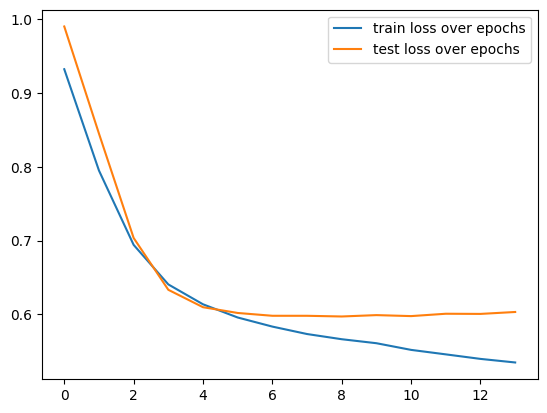

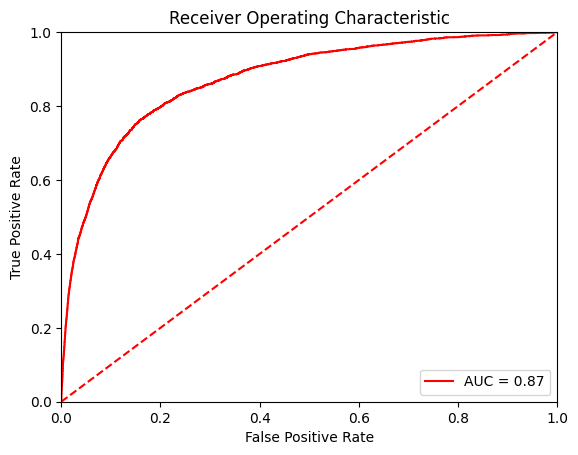

In [16]:
model_3 = CryptoBenchClassifier().to(device)
optimizer = torch.optim.Adam(params=model_3.parameters(),
                            lr=0.0001)

class_weights = compute_class_weights(train_dataset_apo.Ys.numpy()).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])


fpr_3, tpr_3, roc_auc_3 = train(model_3, optimizer, epochs=14, batch_size=4096, loss_fn=loss_fn, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo)